In [1]:
import torch
from utils import load_adj_neg, load_dataset_adj_lap
from model import Encoder
from model import Model
import argparse
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import networkx as nx

In [2]:
from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pylab as pl
from matplotlib import collections  as mc
def visualize(x,y,labels,lap = None, width = 5):
    ss = 1
    #plt.scatter(emb_pca_x,emb_pca_y,s=ss,color='r')
    label_num = labels.max().item()
    colors = ['r','g','b','c','m','y','k','w']
    if lap is not None:
        a = lap_normalized.to_sparse()._indices()
        lines = [[(x[a[0,i]],y[a[0,i]]),(x[a[1,i]],y[a[1,i]])] for i in range(a.shape[1])]
        lc = mc.LineCollection(lines, colors='k', linewidths=width/10)
        fig, ax = pl.subplots()
        ax.add_collection(lc)
        ax.autoscale()
        ax.margins(0.1)
    for i in range(label_num):
        plt.scatter(x[np.nonzero(labels == i)],y[np.nonzero(labels == i)],s=ss,color=colors[i])
    

In [3]:
# NOTE: Splits are randomized and results might slightly deviate from reported numbers in the paper.
import torch
from utils import load_adj_neg, load_dataset_adj_lap
from ssgc import Net
import argparse
import numpy as np
from classification import classify
parser = argparse.ArgumentParser()
dataset = 'cora'
if dataset=='cora':
    nhid = 512
    output = 512
    num_nodes = 2708
    num_features = 1433
    lr = 0.001
    weight_decay = 5e-4
    epoch = 40
    sample = 2
if dataset=='citeseer':
    nhid = 512
    output = 512
    num_nodes = 3327
    num_features = 3703
    lr = 0.0001
    weight_decay = 1e-4
    epoch = 160
    sample = 5
if dataset=='pubmed':
    nhid = 256
    output = 256
    num_nodes = 19717
    num_features = 500
    lr = 0.02
    weight_decay = 1e-5
    epoch = 40
    sample = 3
parser.add_argument('--dataset', type=str, default=dataset,
                    help='dataset')
parser.add_argument('--seed', type=int, default=123,
                    help='seed')
parser.add_argument('--nhid', type=int, default=nhid,
                    help='hidden size')
parser.add_argument('--output', type=int, default=output,
                    help='output size')
parser.add_argument('--lr', type=float, default=lr,
                    help='learning rate')
parser.add_argument('--weight_decay', type=float, default=weight_decay,
                    help='weight decay')
parser.add_argument('--epochs', type=int, default=epoch,
                    help='maximum number of epochs')
parser.add_argument('--sample', type=int, default=sample,
                    help='    ')
parser.add_argument('--num_nodes', type=int, default=num_nodes,
                    help='    ')
parser.add_argument('--num_features', type=int, default=num_features,
                    help='    ')

label_file = open("data/{}{}".format(dataset,"_labels.txt"), 'r')
label_text = label_file.readlines()
labels = []
for line in label_text:
    if line.strip('\n'):
        line = line.strip('\n').split(' ')
        labels.append(int(line[1]))
labels = torch.tensor(labels)


args = parser.parse_args("")
args.device = 'cpu'
torch.manual_seed(args.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

feature, adj_normalized, lap_normalized= load_dataset_adj_lap(args.dataset)
feature = feature.to(device)
adj_normalized = adj_normalized.to(device)
lap_normalized = lap_normalized.to(device)
D = torch.unsqueeze(torch.sum(lap_normalized>0,dim=0),1)

K = 8

feature_poisson_origin = F.normalize(feature)
feature_poisson_origin = feature_poisson_origin - torch.mean(feature_poisson_origin,dim=0)
feature_poisson_origin_degree = feature_poisson_origin/torch.unsqueeze(torch.sum(lap_normalized>0,dim=0),1)
feature_smoothed_poisson = torch.zeros(feature.shape)
adj_poisson = (adj_normalized>0)/D
for i in range(K):
    feature_smoothed_poisson = feature_poisson_origin_degree + torch.mm(adj_poisson, feature_smoothed_poisson)
#feature_smoothed_poisson/=K

/mnt/d/time_eternity/desktop_download_doc_pic_vid_music/Desktop/fp_jupyter_conda/coles_orthonormal/coles_mytry/utils.py:193: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))


In [ ]:
feature_poisson_origin = F.normalize(feature)
feature_poisson_origin = feature_poisson_origin - torch.mean(feature_poisson_origin,dim=0)
feature_smoothed_poisson = torch.zeros(feature.shape)
adj_poisson = (adj_normalized>0)/D
adj_extrinsic_poisson = adj_poisson * (1 - torch.eye(adj_poisson.shape[0]))

for i in range(20):
    feature_smoothed_poisson = feature_poisson_origin/D + torch.mm(adj_extrinsic_poisson, feature_smoothed_poisson)
#feature_smoothed_poisson/=K

#trust = torch.ones([feature.shape[0],1])
#for i in range(K):
#    trust = torch.mm((adj_normalized>0).float(), trust)
#feature_smoothed_poisson/=K
classify(F.normalize(feature_smoothed_poisson)*torch.sqrt(D), args.dataset, per_class='20')
classify(F.normalize(feature_smoothed_poisson)*torch.sqrt(D), args.dataset, per_class='5')

from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA
transformer = decomposition.PCA(n_components=70,
        random_state=0)
#feature_pca = transformer.fit_transform(F.normalize(feature_smoothed_sgc))
feature_pca = transformer.fit_transform(F.normalize(feature_smoothed_poisson)*torch.sqrt(D))
visualize(feature_pca[:,2],feature_pca[:,3],labels,lap_normalized,0.1)


57.67710049423393
4.382749467926512
51.537528430629266
7.214052943308329


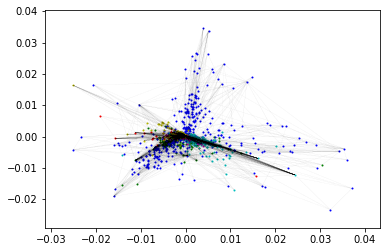

In [14]:
feature_poisson_origin = F.normalize(feature)
feature_poisson_origin = feature_poisson_origin - torch.mean(feature_poisson_origin,dim=0)
feature_smoothed_poisson = torch.zeros(feature.shape)
adj_poisson = (adj_normalized>0)/D
adj_extrinsic_poisson = adj_poisson * (1 - torch.eye(adj_poisson.shape[0]))

for i in range(20):
    feature_smoothed_poisson = feature_poisson_origin/D + torch.mm(adj_extrinsic_poisson, feature_smoothed_poisson)
#feature_smoothed_poisson/=K

#trust = torch.ones([feature.shape[0],1])
#for i in range(K):
#    trust = torch.mm((adj_normalized>0).float(), trust)
#feature_smoothed_poisson/=K
classify(F.normalize(feature_smoothed_poisson)*torch.sqrt(D), args.dataset, per_class='20')
classify(F.normalize(feature_smoothed_poisson)*torch.sqrt(D), args.dataset, per_class='5')

from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA
transformer = decomposition.PCA(n_components=70,
        random_state=0)
#feature_pca = transformer.fit_transform(F.normalize(feature_smoothed_sgc))
feature_pca = transformer.fit_transform(F.normalize(feature_smoothed_poisson)*torch.sqrt(D))
visualize(feature_pca[:,2],feature_pca[:,3],labels,lap_normalized,0.1)


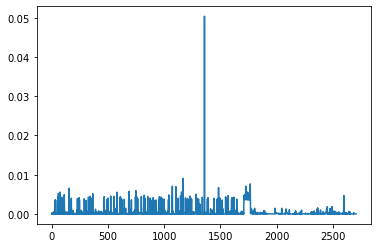

In [12]:
trust = torch.ones([feature.shape[0],1])
for i in range(30):
    trust = torch.mm((adj_normalized>0).float(), trust)
    trust = trust/torch.sum(trust)
feature_smoothed_poisson/=K
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA
plt.plot(trust)

In [22]:
feature_poisson_origin = F.normalize(feature)
feature_poisson_origin = feature_poisson_origin - torch.mean(feature_poisson_origin,dim=0)
feature_smoothed_poisson = torch.zeros(feature.shape)
adj_poisson = (adj_normalized>0)/D
adj_extrinsic_poisson = adj_poisson * (1 - torch.eye(adj_poisson.shape[0]))

feature_smoothed_poisson = feature_poisson_origin/D + torch.mm(adj_extrinsic_poisson, feature_smoothed_poisson)
trust_origin = D
trust_origin = trust_origin/torch.unsqueeze(torch.sum((adj_normalized>0)*torch.transpose(D,0,1),dim = 1),1)
for i in range(20):
    feature_smoothed_poisson = feature_poisson_origin/D*trust_origin + torch.mm(adj_extrinsic_poisson, feature_smoothed_poisson*trust_origin)
     





In [18]:
trust_origin.shape

torch.Size([2708, 2708])

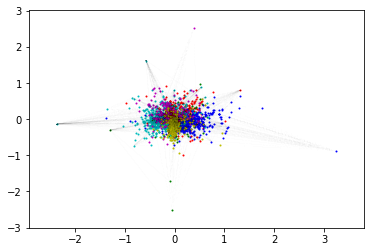

In [25]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA
transformer = decomposition.PCA(n_components=70,
        random_state=0)
#feature_pca = transformer.fit_transform(F.normalize(feature_smoothed_sgc))
feature_pca = transformer.fit_transform(F.normalize(feature_smoothed_poisson)*torch.sqrt(D))
visualize(feature_pca[:,2],feature_pca[:,3],labels,lap_normalized,0.01)

In [24]:
classify(F.normalize(feature_smoothed_poisson)*torch.sqrt(D), args.dataset, per_class='20')
classify(F.normalize(feature_smoothed_poisson)*torch.sqrt(D), args.dataset, per_class='5')

65.95551894563427
1.6562368448220133
48.55344958301744
3.976317453403306


In [ ]:
feature_poisson_origin = F.normalize(feature)
feature_poisson_origin = feature_poisson_origin - torch.mean(feature_poisson_origin,dim=0)


adj_poisson = (adj_normalized>0)/D
adj_extrinsic_poisson = adj_poisson * (1 - torch.eye(adj_poisson.shape[0]))

feature_smoothed_poisson = torch.zeros(feature.shape)
feature_trust = torch.ones([feature.shape[0],1])


for i in range(20):
    feature_smoothed_poisson = feature_poisson_origin/D + torch.mm(adj_extrinsic_poisson,torch.mm(trust,feature_smoothed_poisson))
    feature_trust = feature_trust + torch.mm(adj_extrinsic_poisson,feature_trust)
#feature_smoothed_poisson/=K

#trust = torch.ones([feature.shape[0],1])
#for i in range(K):
#    trust = torch.mm((adj_normalized>0).float(), trust)
#feature_smoothed_poisson/=K
classify(F.normalize(feature_smoothed_poisson)*torch.sqrt(D), args.dataset, per_class='20')
classify(F.normalize(feature_smoothed_poisson)*torch.sqrt(D), args.dataset, per_class='5')

from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA
transformer = decomposition.PCA(n_components=70,
        random_state=0)
#feature_pca = transformer.fit_transform(F.normalize(feature_smoothed_sgc))
feature_pca = transformer.fit_transform(F.normalize(feature_smoothed_poisson)*torch.sqrt(D))
visualize(feature_pca[:,2],feature_pca[:,3],labels,lap_normalized,0.1)


In [ ]:
classify(F.normalize(feature_smoothed_poisson), args.dataset, per_class='20')
classify(F.normalize(feature_smoothed_poisson), args.dataset, per_class='5')

In [ ]:
feature_pca = transformer.fit_transform(F.normalize(feature_smoothed_poisson)*(torch.sqrt(D)))
#feature_pca = transformer.fit_transform(feature_smoothed_poisson*(torch.sqrt(D)))
visualize(feature_pca[:,2],feature_pca[:,3],labels)


In [ ]:
pca = decomposition.FastICA(n_components=512)
feature_ica = pca.fit_transform(feature_smoothed_ssgc)



In [ ]:
pca = decomposition.PCA(n_components=4)
feature_pca = pca.fit_transform(feature_smoothed_ssgc)
#visualize(feature_pca[:,2],feature_pca[:,3],labels,lap_normalized)


In [ ]:
classify(feature_smoothed_poisson*D, args.dataset, per_class='20')
classify(feature_smoothed_poisson*D, args.dataset, per_class='5')
#*torch.sqrt(D)
#*torch.sqrt(D)

In [ ]:
#F.normalize(feature_smoothed_poisson)*(torch.sqrt(D)
classify(F.normalize(feature_smoothed_poisson)*(torch.sqrt(D)), args.dataset, per_class='20')
classify(F.normalize(feature_smoothed_poisson)*(torch.sqrt(D)), args.dataset, per_class='5')

In [ ]:
classify(F.normalize(feature_smoothed_ssgc)*(torch.sqrt(D)), args.dataset, per_class='20')
classify(F.normalize(feature_smoothed_ssgc)*(torch.sqrt(D)), args.dataset, per_class='5')

In [ ]:
classify(feature_smoothed_ssgc, args.dataset, per_class='20')
classify(feature_smoothed_ssgc, args.dataset, per_class='5')

In [ ]:
classify(emb_origin, args.dataset, per_class='20')
classify(emb_origin, args.dataset, per_class='5')

In [ ]:
classify(F.normalize(torch.tensor(emb_origin))*torch.sqrt(D), args.dataset, per_class='20')
classify(F.normalize(torch.tensor(emb_origin))*torch.sqrt(D), args.dataset, per_class='5')

In [ ]:
pca = decomposition.PCA(n_components=10)
feature_pca = pca.fit_transform(F.normalize(torch.tensor(emb_origin)*torch.sqrt(D)))
#feature_pca = pca.fit_transform(torch.tensor(emb_origin))
visualize(feature_pca[:,1],feature_pca[:,2],labels,lap_normalized,0.2)

In [ ]:
pca = decomposition.PCA(n_components=10)
feature_pca = pca.fit_transform(feature*torch.sqrt(D))
#feature_pca = pca.fit_transform(torch.tensor(emb_origin))
visualize(feature_pca[:,0],feature_pca[:,1],labels)

In [ ]:
classify(torch.tensor(feature)*torch.sqrt(D), args.dataset, per_class='20')
classify(torch.tensor(feature)*torch.sqrt(D), args.dataset, per_class='5')

In [ ]:
pca = decomposition.PCA(n_components=10)
feature_pca = pca.fit_transform(F.normalize(torch.tensor(feature)))
#feature_pca = pca.fit_transform(torch.tensor(emb_origin))
visualize(feature_pca[:,1],feature_pca[:,2],labels)